# Procesing DisGeNET for disease-gene relationships

+ [DisGeNET website](http://www.disgenet.org/web/DisGeNET/menu/home)
+ [2015 publication](https://dx.doi.org/10.1093/database/bav028)
+ [2011 publication](https://dx.doi.org/10.1371/journal.pone.0020284)
+ [2010 publication](https://dx.doi.org/10.1093/bioinformatics/btq538)

In [1]:
import pandas
import seaborn

%matplotlib inline

## Data download

In [2]:
# filenames = [
#     'readme.txt',
#     'curated_gene_disease_associations.txt.gz',
#     'literature_gene_disease_associations.txt.gz',
#     'befree_gene_disease_associations.txt.gz',
#     'all_gene_disease_associations.txt.gz',
# ]

# base_url = 'http://www.disgenet.org/ds/DisGeNET/results'

# for filename in filenames:
#     ! wget --timestamping --no-verbose --directory-prefix download {base_url}/{filename}

## Read mappings

In [3]:
# Download and process UMLS to DOID mappings
# We use the propagated mappings here
url = 'https://raw.githubusercontent.com/dhimmel/disease-ontology/72614ade9f1cc5a5317b8f6836e1e464b31d5587/data/xrefs-prop-slim.tsv'
domap_df = pandas.read_table(url)
domap_df = domap_df.query('resource == "UMLS"')
domap_df['diseaseId'] = 'umls:' + domap_df['resource_id']
domap_df = domap_df[['doid_code', 'doid_name', 'diseaseId']]
domap_df.head(3)

,doid_code,doid_name,diseaseId
513,DOID:2531,hematologic cancer,umls:C0001815
514,DOID:2531,hematologic cancer,umls:C0002890
515,DOID:2531,hematologic cancer,umls:C0006413


## Read data

In [4]:
all_df = pandas.read_table('download/all_gene_disease_associations.txt.gz')
all_df = domap_df.merge(all_df)
all_df.head(2)

,doid_code,doid_name,diseaseId,geneId,geneSymbol,geneName,diseaseName,score,NumberOfPubmeds,associationType,source
0,DOID:2531,hematologic cancer,umls:C0001815,3717,JAK2,Janus kinase 2,Primary Myelofibrosis,0.371838,242,"AlteredExpression, Biomarker, GeneticVariation","BeFree, CTD_human, GAD, LHGDN"
1,DOID:2531,hematologic cancer,umls:C0001815,2146,EZH2,enhancer of zeste 2 polycomb repressive comple...,Primary Myelofibrosis,0.210284,2,Biomarker,"BeFree, CTD_human"


In [5]:
len(all_df)

129982

In [6]:
all_df.doid_code.nunique()

125

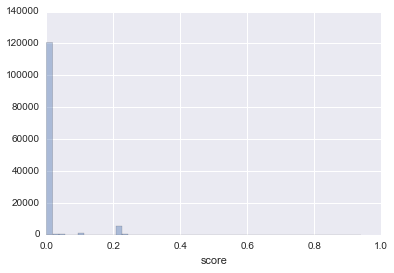

In [ ]:
seaborn.distplot(all_df.score, kde=False);

## Consolidate by DO and Entrez Gene terms

In [ ]:
def consolidator(df):
    """Consolidate rows of all_df"""
    series = pandas.Series()
    series['count'] = len(df)
    series['pubmeds_max'] = df.NumberOfPubmeds.max()
    series['score_max'] = df.score.max()
    series['score_mean'] = df.score.mean()
    for column in ['associationType', 'source']:
        values = set()
        for x in df[column]:
            values.update(x.split(', '))
        series[column] = '|'.join(sorted(values))
    return series

consolidated_df = all_df.groupby(['doid_code', 'doid_name', 'geneId', 'geneSymbol']).apply(consolidator).reset_index()
consolidated_df = consolidated_df.sort(['doid_code', 'score_max'], ascending=[True, False])
consolidated_df.head(2)

In [ ]:
consolidated_df.to_csv('data/consolidated.tsv', sep='\t', index=False)

In [ ]:
len(consolidated_df)

In [ ]:
hps_df = consolidated_df[consolidated_df.score_max >= 0.06]
len(hps_df)

In [ ]:
hps_df.query("doid_name == 'multiple sclerosis'").head(15)

In [ ]:
seaborn.distplot(hps_df.doid_name.value_counts())

## Identify UMLS CUIs that are DO Slim xrefs but not is DisGeNET

In [ ]:
url = 'https://raw.githubusercontent.com/dhimmel/disease-ontology/72614ade9f1cc5a5317b8f6836e1e464b31d5587/data/xrefs-slim.tsv'
domap_df = pandas.read_table(url)
domap_df = domap_df.query('resource == "UMLS"')
domap_df['diseaseId'] = 'umls:' + domap_df['resource_id']
domap_df = domap_df[['doid_code', 'doid_name', 'diseaseId']]
unmapped_df = domap_df[-domap_df.diseaseId.isin(all_df.diseaseId)]
unmapped_df.to_csv('data/unmapped-umls.tsv', sep='\t', index=False)